  ***
  ***
  
  #  Computational Astrophysics HW#2
  ## Mario L. Gutierrez Abed
  
  ***
  ***

<font color='red'> <em> <b> Exercise 1) </b> </em> </font> 

Develop an adaptive Runge-Kutta algorithm based on the standard fourth-order accurate RK4 algorithm.
To estimate the local error, calculate $f(x_0 + h)$ using RK4 with stepsize $h$ and with two RK4 steps using
stepsize $h/2$. The difference between these two will be your estimate of the local error. Test your code by
solving 

\begin{align}  
    y''(x) &= -y,       \, \, \, \, \,  \, \, \, \,   0 \leq x \leq 10   \label{eq:Prob1Eq} \\  
    y(0)   &= 0,        \nonumber  \\
    y'(0)  &= 1.     \nonumber 
\end{align}



Measure the $L^\infty$-norm of the error. Note that your code should automatically choose the stepsize $h$ based on the user-specified tolerance. Try to set the tolerance to just above the roundoff limit.


#### <em> Solution:</em>
Our starting point for solving an ODE of the form $y'(x) = f(x,y)$ is the standard fourth-order Runge-Kutta method, with some grid-spacing $\hat{h}$:

\begin{equation}\label{eq:RK4}
    \hat{y}_{i+1} = \hat{y}_i + \frac{\hat{h}}{6} \left( k_1 + 2k_2 + 2k_3 + k_4 \right),
\end{equation}


where

\begin{align*}  
    k_1 &= f(x_i, \hat{y}_i)      \\
    k_2 &= f \left( x_i + \frac{1}{2} \hat{h},  \hat{y}_i + \frac{1}{2} \hat{h} \, k_1 \right)   \\
    k_3 &= f \left( x_i + \frac{1}{2} \hat{h},  \hat{y}_i + \frac{1}{2} \hat{h} \, k_2 \right)   \\
    k_4 &= f \left( x_i + \hat{h},  \hat{y}_i +  \hat{h} \, k_3 \right).
\end{align*}


For the purpose of estimating the local error, we shall simultaneously run the RK4 algorithm with a different stepsize $\tilde{h} = \hat{h}/2$. Thus a step of Eq. \eqref{eq:RK4} will be run in parallel with two steps of

\begin{equation}\label{eq:RK4_htilde}
    \tilde{y}_{i+1} = \tilde{y}_i + \frac{\tilde{h}}{6} \left( k_1 + 2k_2 + 2k_3 + k_4 \right).
\end{equation}

At each step we check whether $\delta \equiv \Vert \tilde{y} - \hat{y} \Vert_\infty \leq \varepsilon$, where $\varepsilon$ is some user-defined tolerance. Then, the step size $h$ is changed according the following condition:

\begin{equation}\label{eq:Step_Size_Cond}
    h_{\text{new}} = 
        \begin{cases}
        Sh \left( \frac{\varepsilon}{\delta} \right)^{1/5} \, &\text{if $\delta \leq \varepsilon$},  \\
        Sh \left( \frac{\varepsilon}{\delta} \right)^{1/4} \, &\text{otherwise}.
        \end{cases}
\end{equation}

Here $S$ is a safety factor (typically, $0.5 \leq S \leq 0.9$) which is introduced to prevent $h$ from increasing/decreasing drastically. 


In [1]:
import numpy as np

def rk4_step(x_i, y_i, rhs_func, h, **kwargs):
    k1 = rhs_func(x_i, y_i, **kwargs)
    k2 = rhs_func(x_i + h/2.0, y_i + h/2.0 * k1, **kwargs)
    k3 = rhs_func(x_i + h/2.0, y_i + h/2.0 * k2, **kwargs)
    k4 = rhs_func(x_i + h, y_i + h * k3, **kwargs)
    
    return x_i + h, y_i + h/6.0 * (k1 + 2.0*k2 + 2.0*k3 + k4)


def solution_on_grid(x0            = 0.0, 
                     xf            = 1.0, 
                     y0            = None, 
                     rhs_func      = None,
                     h0            = 0.1,
                     safety_factor = 0.8,
                     tol           = 1e-10):
   
    grid  = []
    yvals = []
    
    grid.append(x0)
    yvals.append(y0)
    
    h       = h0
    x_hat   = x0
    y_hat   = y0
    x_tilde = x0
    y_tilde = y0

    it     = 0
    it_max = 1000
    h_min  = 1e-14
    
    
    while x_hat <= xf:
                       
        x_old = x_tilde
        y_old = y_tilde
        
        x_hat,   y_hat   = rk4_step(x_hat,   y_hat,   rhs_func, h)
        x_tilde, y_tilde = rk4_step(x_tilde, y_tilde, rhs_func, h/2.0)
        x_tilde, y_tilde = rk4_step(x_tilde, y_tilde, rhs_func, h/2.0)  #run twice
        
        assert  np.abs(x_tilde - x_hat) < 1e-10
        delta = np.max(np.abs(y_tilde - y_hat))
        
        if h <= h_min:
            print(f'h = {h} has reached a value that is too low. Breaking the loop now...')
            break
        
        if delta <= tol:
            h     = safety_factor * h * (tol/delta) ** 0.20              
            y_hat = y_tilde         
            it    = 0        # reset condition
            
            grid.append(x_tilde)
            yvals.append(y_tilde)
            
        else:
            h       = safety_factor * h * (tol/delta) ** 0.25
            x_tilde = x_old
            y_tilde = y_old
            x_hat   = x_old
            y_hat   = y_old
                
            it+=1
            if it==it_max:
                print(f'Tolerance never reached..Breaking the code after {it_max} iterations...')
                break
    
    grid  = np.array(grid)
    yvals = np.array(yvals)

    return grid, yvals

Now, the closed-form general solution to Eq. \eqref{eq:Prob1Eq} is given by

\begin{equation}\label{eq:Prob1EqAnSolGeneral}
    y(x) = c_0 \cos{x}  + c_1 \sin{x}, \, \, \, \, \, \, \, c_0, c_1 \in \mathbb{R}.
\end{equation}

Given the stated initial conditions, we find $c_0 = 0$, $c_1 = 1$, so that the solution to our particular problem is 

\begin{equation}\label{eq:Prob1EqAnSol}
    y(x) = \sin{x}.
\end{equation}

However, for the purpose of solving the system using the Runge-Kutta method, we do the usual trick of writing down the given second-order system as a pair of first-order equations, using an auxiliary function $\varphi$:

\begin{equation}\label{eq:Prob1EqVer2}
    \begin{bmatrix}
    y'   \\
    \varphi'
    \end{bmatrix}
    =
   \begin{bmatrix}
    \varphi   \\
    -y
    \end{bmatrix}.
\end{equation}


<IPython.core.display.Latex object>

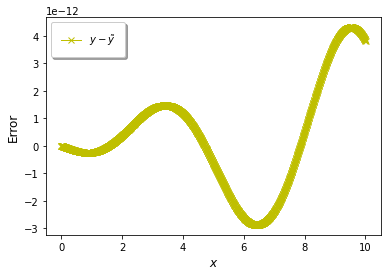

In [2]:
import matplotlib.pyplot as plt
from IPython.display import display, Latex

def rhs(x, y_array, **kwargs):
    # y_array = (y, y') 
    return np.array((y_array[1], - y_array[0]))


def exact_sol(x, y_initial):
    c0      = y_initial[0]
    c1      = y_initial[1]
    y       =  c0 * np.cos(x) + c1 * np.sin(x)   # = y
    y_prime = -c0 * np.sin(x) + c1 * np.cos(x)   # = y'
    
    return y, y_prime


# initial conditions (y_init[0] = y(0) = 0, y_init[1] = y'(0) = 1)
y_init = np.array((0.0,1.0))


grid, yvals = solution_on_grid(x0            = 0.0, 
                               xf            = 10.0,
                               y0            = y_init,
                               rhs_func      = rhs, 
                               h0            = 0.1,
                               safety_factor = 0.8,
                               tol           = 1e-13)


y_exact     = exact_sol(grid, y_init)
error       = yvals[:,0] - y_exact[0]
l_inf_error = np.linalg.norm(yvals[:,0] - y_exact[0], ord=np.inf)

display(Latex(f'The $L_\infty$-norm error is {l_inf_error}.'))

plt.plot(grid, error, 'yx-', linewidth=1, label=r'$y - \tilde{y}$')
plt.legend(fancybox=True, framealpha=1, borderpad=1, shadow=True,  loc='upper left')
plt.xlabel(r'$x$',  fontsize=12);
plt.ylabel('Error', fontsize=12);

plt.show()

# save plot     
# plt.savefig('./Figures/y_versus_ytilde.pdf', bbox_inches='tight') 
# plt.close()

This concludes the exercise. $\blacksquare$
***



<font color='red'> <em> <b> Exercise 2) </b> </em> </font> 

Express the equations of motion for three gravitating point masses in Newtonian gravity in first order form. Implement your system of equations within the adaptive RK4 integrator you developed in Problem 1. Finally, using your code, solve the problem of three masses initially at rest and arranged on the vertices of a right triangle whose sides have length $3\ell$, $4\ell$, and $5\ell$. Choose the masses to be proportional to the side opposite the given vertex. Confirm that you can rescale the space and time coordinates so that the masses are $3$, $4$, and $5$, the lengths to be $3$, $4$, and $5$, and the gravitational constant to be $G=1$, and solve this problem numerically. Plot the trajectories of the three masses on a single plot. In addition, measure the total energy, linear, and angular momentum and determine how well these are conserved as a function of
the tolerance.


#### <em> Solution:</em>
The equations of motion for three gravitating point masses $m_i$ with positions $\vec{r}_i = (x_i, y_i) \in \mathbb{R}^2$ in Newtonian gravity are given by 

\begin{equation}\label{eq:Newt_Grav_EoM}
    \ddot{\vec{r}}_i = - G m_j \frac{\vec{r}_i - \vec{r}_j}{\Vert \vec{r}_i - \vec{r}_j \Vert^3} 
                 - G m_k \frac{\vec{r}_i - \vec{r}_k}{\Vert \vec{r}_i - \vec{r}_k \Vert^3},
\end{equation}

where $i,j,k = 0,1,2$ and $i \neq j \neq k$, $G$ is Newton's gravitational constant (we shall set $G=1$ in the code), and $\Vert \cdot \Vert$ is the Euclidean norm. For instance, for $\vec{r}_0$ we have

\begin{align*}
    \ddot{\vec{r}}_0 = 
    \begin{bmatrix}
    \ddot{x}_0  \\
    \ddot{y}_0
    \end{bmatrix}
      &=  -    \frac{G m_1}{\Vert \vec{r}_0 - \vec{r}_1 \Vert^3}
               \begin{bmatrix}
                 x_0 - x_1  \\
                 y_0 - y_1
                \end{bmatrix}
          -     \frac{G m_2}{\Vert \vec{r}_0 - \vec{r}_2 \Vert^3}  
                \begin{bmatrix}
                 x_0 - x_2  \\
                 y_0 - y_2
                \end{bmatrix},   
      \nonumber \\
\end{align*}


and similarly for $\vec{r}_1, \, \vec{r}_2$. This is a system of six second-order differential equations, which we then rewrite as a system of 
first-order equations

\begin{equation}\label{eq:Newt_Grav_EoM_Vectorized}
    \begin{bmatrix}
    \dot{\vec{r}}_i        \\
    \dot{\vec{\varphi}}_i
    \end{bmatrix}
    =
   \begin{bmatrix}
    \vec{\varphi}_i   \\
    \vec{\Theta}_{ijk}
    \end{bmatrix},
\end{equation}

where we set

\begin{equation}\label{eq:Theta_ijk}
    \vec{\Theta}_{ijk} \equiv - G m_j \frac{\vec{r}_i - \vec{r}_j}{\Vert \vec{r}_i - \vec{r}_j \Vert^3} 
                        - G m_k \frac{\vec{r}_i - \vec{r}_k}{\Vert \vec{r}_i - \vec{r}_k \Vert^3}, 
\end{equation}



and $\varphi$ is some auxiliary function.  


<div>
    <img src="Figures/triangle.jpg" width="300"/>
</div>


We choose the masses to be proportional to the side opposite the given vertex, so we have

\begin{align*}
    m_{3\ell} &= \alpha_{3\ell} 3 \ell   \\
    m_{4\ell} &= \alpha_{4\ell} 4 \ell   \\
    m_{5\ell} &= \alpha_{5\ell} 5 \ell,
\end{align*}

for some $\alpha$ coefficients that depend on the length $\ell$ (we can just set them all to $1$ for all intent and purposes).  To tidy up the notation, we shall set 

\begin{equation*}
    m_0 \equiv m_{5\ell}, \, \, \, \, \,  m_1 \equiv m_{4\ell}, \, \, \, \, \, m_2 \equiv m_{3\ell}
\end{equation*}

  
\begin{equation*}
    \alpha_0 \equiv \alpha_{5\ell}, \, \, \, \, \,  
    \alpha_1 \equiv \alpha_{4\ell}, \, \, \, \, \, 
    \alpha_2 \equiv \alpha_{3\ell}
\end{equation*}

   

and, WLOG, we choose to position the point mass $m_0$ initially at the origin of $\mathbb{R}^2$, so that initially we have the locations

$$
   \vec{r}_0^{(0)} = (x_0, y_0) = (0,0),      \, \, \, \, \,   
   \vec{r}_1^{(0)} = (x_1, y_1) = (3\ell, 0), \, \, \, \, \,
   \vec{r}_2^{(0)} = (x_2, y_2) = (0,4 \ell).
$$

In [3]:
# set the desired length, alpha, and mass 
ell   = 1.0 
alpha = np.array((1.0, 2.0, 3.0))
mass  = np.array((alpha[0]*5.0*ell, alpha[1]*4.0*ell, alpha[2]*3.0*ell))


def dist(r_i, r_j):
    return np.sqrt( (r_i[0] - r_j[0])**2 + (r_i[1] - r_j[1])**2 )


def newton_rhs(x, r_array, G=1.0, m = mass):
    '''
        Refer to Eq. (10) 
        r_array = (r0,r1,r2,\dot{r0},\dot{r1},\dot{r2})
        alpha proportionality constants could be anything..
    '''
    
    theta_0 = np.zeros(2)   #\ddot{r}_0
    theta_1 = np.zeros(2)   #\ddot{r}_1
    theta_2 = np.zeros(2)   #\ddot{r}_2
    
    for i in range(0,2):
        theta_0[i] = - G * m[1] * (r_array[0,i] - r_array[1,i]) / (dist(r_array[0], r_array[1]))**3   \
                     - G * m[2] * (r_array[0,i] - r_array[2,i]) / (dist(r_array[0], r_array[2]))**3   
        
        theta_1[i] = - G * m[0] * (r_array[1,i] - r_array[0,i]) / (dist(r_array[1], r_array[0]))**3   \
                     - G * m[2] * (r_array[1,i] - r_array[2,i]) / (dist(r_array[1], r_array[2]))**3 
        
        theta_2[i] = - G * m[0] * (r_array[2,i] - r_array[0,i]) / (dist(r_array[2], r_array[0]))**3   \
                     - G * m[1] * (r_array[2,i] - r_array[1,i]) / (dist(r_array[2], r_array[1]))**3 
     
     
    theta = np.array((theta_0, theta_1, theta_2))
    rhs   = np.array((r_array[3:], theta))   # Eq. (9)
    rhs   = rhs.reshape(6,2)    # reshaping to make the array compatible with RK4 routine
    
    return rhs
    
# initial conditions
r_init = ((0.0,0.0), (3.0*ell,0.0), (0.0,4.0*ell), (0.0,0.0), (0.0,0.0), (0.0,0.0))
r_init = np.array(r_init)

Time to plot the trajectories. Note that this time `x0` and `xf` actually refer to time parameters, just as `y0` actually refers to the initial separations and velocities of the particles as described above. 

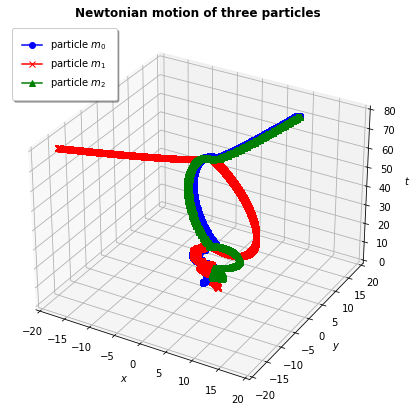

In [26]:
newton_time, newton_vals = solution_on_grid(x0            = 0.0,       #t_start
                                            xf            = 80.0,      #t_final
                                            y0            = r_init,
                                            rhs_func      = newton_rhs, 
                                            h0            = 0.1,
                                            safety_factor = 0.8,
                                            tol           = 1e-5)


# Grab positions (x,y) of all three particles
particle_m0_x_position = newton_vals[:,0][:,0]
particle_m0_y_position = newton_vals[:,0][:,1]

particle_m1_x_position = newton_vals[:,1][:,0]
particle_m1_y_position = newton_vals[:,1][:,1]

particle_m2_x_position = newton_vals[:,2][:,0]
particle_m2_y_position = newton_vals[:,2][:,1]


# Plot trajectories
fig = plt.figure(figsize = (10, 7))
ax  = plt.axes(projection ="3d")

ax.plot(particle_m0_x_position, particle_m0_y_position, newton_time, 
        marker = 'o', color = "blue",  label=r'particle $m_0$')
ax.plot(particle_m1_x_position, particle_m1_y_position, newton_time, 
        marker = 'x', color = "red",   label=r'particle $m_1$')
ax.plot(particle_m2_x_position, particle_m2_y_position, newton_time, 
        marker = '^', color = "green", label=r'particle $m_2$')

plt.legend(fancybox=True, framealpha=1, borderpad=1, shadow=True,  loc='upper left')

ax.set_xlim(-20,20)
ax.set_ylim(-20,20)

ax.set_xlabel(r'$x$', fontweight ='bold')
ax.set_ylabel(r'$y$', fontweight ='bold')
ax.set_zlabel(r'$t$', fontweight ='bold')

plt.title("Newtonian motion of three particles", fontweight ='bold')

plt.show() 

# save plot     
# plt.savefig('./Figures/newtonian_motion.pdf', bbox_inches='tight') 
# plt.close()

We could also do a movie of the evolution. I do this with the `celluloid` package, which can be installed via conda with the command
```
   conda install -c coecms celluloid
```
or via `pip` with
```
   pip install celluloid
```

<div class="alert alert-block alert-warning">
<b>Warning!:</b> The full evolution is quite expensive! 
</div>

In [ ]:
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera 
import time
%matplotlib inline

'''
    Set start/stop time for the evolution. 
    Running the full evolution is quite expensive.
'''
t_min = 0
t_max = 50


# Load trajectory data
traj_X0 = particle_m0_x_position[t_min:t_max]
traj_Y0 = particle_m0_y_position[t_min:t_max]

traj_X1 = particle_m1_x_position[t_min:t_max]
traj_Y1 = particle_m1_y_position[t_min:t_max]

traj_X2 = particle_m2_x_position[t_min:t_max]
traj_Y2 = particle_m2_y_position[t_min:t_max]

traj_T = newton_time[t_min:t_max]


# Animate the trajectories
fig = plt.figure(figsize = (10, 7))
ax  = plt.axes(projection ="3d")


# Initiate camera
camera = Camera(fig)

tic = time.time()

# Create individual frames
for j in range(1,len(traj_T)+1):
    
    # Trajectories of the three particles
    x0 = traj_X0[0:j]
    y0 = traj_Y0[0:j]
    
    x1 = traj_X1[0:j]
    y1 = traj_Y1[0:j]
    
    x2 = traj_X2[0:j]
    y2 = traj_Y2[0:j]
    
    t = traj_T[0:j]
    
    # show locations
    ax.plot(x0[-1], y0[-1], t[-1], marker = 'o', color = "blue",  label=r'particle $m_0$')
    ax.plot(x1[-1], y1[-1], t[-1], marker = 'x', color = "red",   label=r'particle $m_1$')
    ax.plot(x2[-1], y2[-1], t[-1], marker = '^', color = "green", label=r'particle $m_2$')
    
    # show trajectories
    ax.plot(x0, y0, t, color='b', lw=2, linestyle='--')
    ax.plot(x1, y1, t, color='r', lw=2, linestyle='--')
    ax.plot(x2, y2, t, color='g', lw=2, linestyle='--')    
    
    ax.set_xlabel(r'$x$', fontweight ='bold')
    ax.set_ylabel(r'$y$', fontweight ='bold')
    ax.set_zlabel(r'$t$', fontweight ='bold')
    
    # output the legend+title just once, at the beginning
    if j == 1:
        plt.legend(fancybox=True, framealpha=1, borderpad=1, shadow=True,  loc='upper left')
        plt.title("Newtonian motion of three particles", fontweight ='bold')
    
    # Capture frame
    camera.snap()

# Create and save animation
anim = camera.animate(interval = 40, repeat = True, repeat_delay = 500)
# anim.save('three_body_evolution.mp4')

toc = time.time()

print(f'It took {(toc-tic)/60.0} minutes to run this evolution.')

# Inline display
HTML(anim.to_html5_video())

To conclude this exercise, we are going to calculate the total linear- and angular momenta ($\vec{P}_\text{total}$ and $\vec{S}_\text{total}$, respectively), as well as the total energy $\vec{E}_\text{total}$ of the system. These quantities are given by

\begin{align}
    \vec{P}_\text{total} &=  \sum_{i=0}^2 m_i \dot{\vec{r}}_i   \nonumber \\
                         &= m_0 
                             \begin{bmatrix}
                             \dot{x}_0   \\
                             \dot{y}_0
                             \end{bmatrix}   +
                            m_1 
                             \begin{bmatrix}
                             \dot{x}_1   \\
                             \dot{y}_1
                             \end{bmatrix}   +
                            m_2 
                             \begin{bmatrix}
                             \dot{x}_2   \\
                             \dot{y}_2
                             \end{bmatrix}.   \label{eq:p_total} \\ 
    \vec{S}_\text{total} &=  \sum_{i=0}^2 m_i \vec{r}_i \times \dot{\vec{r}}_i  \nonumber \\
                         &=  \sum_{i=0}^2 m_i \sum_{j,k}  \epsilon^{2jk} (\vec{r}_i)_j  
                             (\dot{\vec{r}}_i)_k  \nonumber \\
                         &= m_0 
                             \begin{bmatrix}
                              0    \\
                              0    \\
                              x_0 \dot{y}_0  - y_0 \dot{x}_0
                             \end{bmatrix}   +
                            m_1 
                             \begin{bmatrix}
                              0    \\
                              0    \\
                              x_1 \dot{y}_1  - y_1 \dot{x}_1
                             \end{bmatrix}   +
                            m_2 
                             \begin{bmatrix}
                              0    \\
                              0    \\
                              x_2 \dot{y}_2  - y_2 \dot{x}_2
                             \end{bmatrix}.   \label{eq:s_total}  \\          
    \vec{E}_\text{total} &=  \sum_{i=0}^2 \frac{1}{2} m_i \dot{\vec{r}}_i  \cdot \dot{\vec{r}}_i
                             - \sum_{k \neq j} \frac{G m_k m_j}{\Vert r_k - r_j \Vert}   \label{eq:e_total} \\
\end{align}

We have already extracted the positions of the particles at the end of our run in the codes above; we now do the same for the velocities:

In [27]:
# Grab velocities (\dot{x}, \dot{y}) of all three particles
particle_m0_x_speed = newton_vals[:,3][:,0]
particle_m0_y_speed = newton_vals[:,3][:,1]

particle_m1_x_speed = newton_vals[:,4][:,0]
particle_m1_y_speed = newton_vals[:,4][:,1]

particle_m2_x_speed = newton_vals[:,5][:,0]
particle_m2_y_speed = newton_vals[:,5][:,1]

We now use the last elements of the above data to calculate the quantities on Eqs \eqref{eq:p_total}-\eqref{eq:e_total}: 

In [28]:
# Collect data from end of evolution
x0     = particle_m0_x_position[-1]
y0     = particle_m0_y_position[-1]
x0_dot = particle_m0_x_speed[-1]
y0_dot = particle_m0_y_speed[-1]

x1     = particle_m1_x_position[-1]
y1     = particle_m1_y_position[-1]
x1_dot = particle_m1_x_speed[-1]
y1_dot = particle_m1_y_speed[-1]

x2     = particle_m2_x_position[-1]
y2     = particle_m2_y_position[-1]
x2_dot = particle_m2_x_speed[-1]
y2_dot = particle_m2_y_speed[-1]


''' ----------------
     Solve Eq. (12)
    ----------------
'''
Px      = mass[0] * x0_dot + mass[1] * x1_dot + mass[2] * x2_dot 
Py      = mass[0] * y0_dot + mass[1] * y1_dot + mass[2] * y2_dot 
P_total = np.array((Px,Py))

P_total_start = 0.0 # trivial, from the initial conditions



''' ----------------
     Solve Eq. (13)
    ----------------
'''
Sx = 0.0
Sy = 0.0
Sz = mass[0] * (x0*y0_dot - y0*x0_dot) + \
     mass[1] * (x1*y1_dot - y1*x1_dot) + \
     mass[2] * (x2*y2_dot - y2*x2_dot)

S_total = np.array((Sx,Sy,Sz))

S_total_start = 0.0 # trivial, from the initial conditions


''' ----------------
     Solve Eq. (14)
    ----------------
'''
G  = 1.0

r0 = np.array((x0,y0))
r1 = np.array((x1,y1))
r2 = np.array((x2,y2))

r0_dot = np.array((x0_dot,y0_dot))
r1_dot = np.array((x1_dot,y1_dot))
r2_dot = np.array((x2_dot,y2_dot))


# Collect data from beginning of evolution
x0_start = particle_m0_x_position[0]
y0_start = particle_m0_y_position[0]

x1_start = particle_m1_x_position[0]
y1_start = particle_m1_y_position[0]

x2_start = particle_m2_x_position[0]
y2_start = particle_m2_y_position[0]

r0_start = np.array((x0_start,y0_start))
r1_start = np.array((x1_start,y1_start))
r2_start = np.array((x2_start,y2_start))


E_total = 0.5 * (mass[0] * np.dot(r0_dot,r0_dot) + \
                 mass[1] * np.dot(r1_dot,r1_dot) + \
                 mass[2] * np.dot(r2_dot,r2_dot) ) \
           - G * mass[0] * mass[1] / dist(r0, r1) \
           - G * mass[0] * mass[2] / dist(r0, r2) \
           - G * mass[1] * mass[2] / dist(r1, r2) 


E_total_start = - G * mass[0] * mass[1] / dist(r0_start, r1_start) \
                - G * mass[0] * mass[2] / dist(r0_start, r2_start) \
                - G * mass[1] * mass[2] / dist(r1_start, r2_start) 



''' ----------------
     Print results
    ----------------
'''

P_diff = np.max(np.abs(P_total - P_total_start))
print(f'The change in linear momentum is {P_diff}.')

S_diff = np.max(np.abs(S_total - S_total_start))
print(f'The change in angular momentum is {S_diff}.')

E_diff = np.abs(E_total - E_total_start)
print(f'The change in energy is {E_diff}.')

The change in linear momentum is 8.778755500316038e-12.
The change in angular momentum is 1.972466634470038e-11.
The change in energy is 6.719219882711513e-07.


We now plot these changes as a function of the user-defined tolerance:

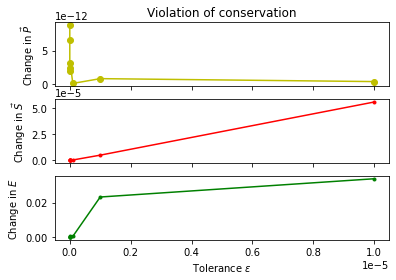

In [34]:
tol_array    = np.array((1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12))
P_diff_array = np.array((3.6376457401843254e-13, 8.029132914089132e-13, 
                         9.059419880941277e-14,  3.154809746774845e-12, 
                         2.411626454090765e-12,  1.9682033780554775e-12, 
                         6.538991570437247e-12,  8.778755500316038e-12))
S_diff_array = np.array((5.570849376113074e-05,  4.783419512932596e-06, 
                         1.5867068370312154e-07, 8.644178706163075e-08, 
                         2.8119586659158813e-09, 4.4076386984670535e-10, 
                         1.0754774848464876e-10, 1.972466634470038e-11))
E_diff_array = np.array((0.03385164606898172,   0.023219854908944626, 
                         0.0003271348054596501, 0.0005056144784560956, 
                         9.011379709988887e-06, 6.269771901656895e-07, 
                         6.140238326679537e-07, 6.719219882711513e-07))

# Create three subplots sharing x axis
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, sharex=True)

ax1.plot(tol_array, P_diff_array, 'yo-')
ax1.set(title='Violation of conservation', ylabel=r'Change in $\vec{P}$')

ax2.plot(tol_array, S_diff_array, 'r.-')
ax2.set(ylabel=r'Change in $\vec{S}$')

ax3.plot(tol_array, E_diff_array, 'g.-')

ax3.set(xlabel=r'Tolerance $\varepsilon$', ylabel=r'Change in $E$')

# plt.show()
# save plot     
plt.savefig('./Figures/violation_tol.pdf', bbox_inches='tight') 
# plt.close()

From the plots we can see that all three quantities are indeed conserved. However, we notice that for the linear momentum the conservation is violated more as we decrease the tolerance, which is the opposite behavior of the other two quantities (and of what we expect). That being said, the violation is still quite small. $\blacksquare$

***